In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import re
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

### Clear day-ahead renewable profile

In [3]:
# Specify the directory you want to use
directory = './DAM/Renewable'

dataframes = []  # list to store dataframes
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename), encoding='ISO-8859-1')
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)
df_sorted = combined_df.sort_values(by=['OPR_DT', 'OPR_HR',]).reset_index(drop=True)
df_sorted['INTERVALSTARTTIME_GMT'] = pd.to_datetime(df_sorted['INTERVALSTARTTIME_GMT'])

In [4]:
solar_data = df_sorted[df_sorted['RENEWABLE_TYPE'] == 'Solar']
wind_data = df_sorted[df_sorted['RENEWABLE_TYPE'] == 'Wind']

# Group and sum MW by INTERVALSTARTTIME_GMT and TRADING_HUB for solar
solar_grouped = solar_data.groupby(['INTERVALSTARTTIME_GMT', 'TRADING_HUB'])['MW'].sum().unstack()
train_pre_solar = pd.DataFrame()
train_pre_solar['CAISO'] = solar_grouped.sum(axis=1)
train_pre_solar['Zone1'] = solar_grouped['NP15']
train_pre_solar['Zone2&3'] = solar_grouped[['SP15', 'ZP26']].sum(axis=1)

# Group and sum MW by INTERVALSTARTTIME_GMT and TRADING_HUB for wind
wind_grouped = wind_data.groupby(['INTERVALSTARTTIME_GMT', 'TRADING_HUB'])['MW'].sum().unstack()
train_pre_wind = pd.DataFrame()
train_pre_wind['CAISO'] = wind_grouped.sum(axis=1)
train_pre_wind['Zone1'] = wind_grouped['NP15']
train_pre_wind['Zone2&3'] = wind_grouped[['SP15']].sum(axis=1)

# Set INTERVALSTARTTIME_GMT as index for both DataFrames
train_pre_solar.index.name = 'INTERVALSTARTTIME_GMT'
train_pre_wind.index.name = 'INTERVALSTARTTIME_GMT'

In [5]:
DAMSolar = train_pre_solar.resample('5T').ffill()
DAMWind = train_pre_wind.resample('5T').ffill()


C:\Users\wenmi\AppData\Local\Temp\ipykernel_17564\3712915441.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  DAMSolar = train_pre_solar.resample('5T').ffill()
C:\Users\wenmi\AppData\Local\Temp\ipykernel_17564\3712915441.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  DAMWind = train_pre_wind.resample('5T').ffill()


### K-Means training

In [6]:
reshaped_data_solar = train_pre_solar[['CAISO', 'Zone1', 'Zone2&3']].values.reshape(-1, 24*3)/max(train_pre_solar['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features
reshaped_data_wind = train_pre_wind[['CAISO', 'Zone1', 'Zone2&3']].values.reshape(-1, 24*3)/max(train_pre_wind['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features

kmeans_solar = KMeans(n_clusters= 8, random_state=0).fit(reshaped_data_solar)
kmeans_wind = KMeans(n_clusters= 8, random_state=0).fit(reshaped_data_wind)

labels_solar = kmeans_solar.labels_  # the label of the cluster each data point belongs to
labels_wind = kmeans_wind.labels_  # the label of the cluster each data point belongs to

C:\Users\wenmi\.conda\envs\STESTS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wenmi\.conda\envs\STESTS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


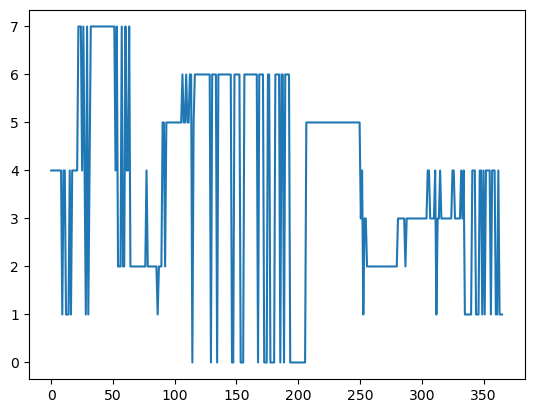

In [7]:
x1 = np.linspace(0, 365, 365)
y1 = labels_solar

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x1, y1)

# Show the plot
plt.show()

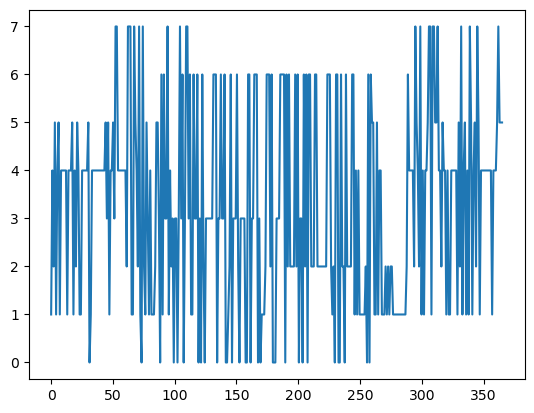

In [8]:
x2 = np.linspace(0, 365, 365)
y2 = labels_wind

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x2, y2)

# Show the plot
plt.show()

### Clear real-time renewable profile


In [10]:
# Specify the directory you want to use
directory = './RTD/Renewable'

dataframes = []  # list to store dataframes
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename), encoding='ISO-8859-1')
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

In [11]:
combined_df = combined_df.sort_values(by=['INTERVALSTARTTIME_GMT', 'TRADING_HUB']).reset_index(drop=True)

In [12]:
solar_data_rtd = combined_df[combined_df['RENEWABLE_TYPE'] == 'Solar'].reset_index(drop=True)[['INTERVALSTARTTIME_GMT', 'TRADING_HUB', 'MW']]
wind_data_rtd = combined_df[combined_df['RENEWABLE_TYPE'] == 'Wind'].reset_index(drop=True)[['INTERVALSTARTTIME_GMT', 'TRADING_HUB', 'MW']]

In [13]:
solar_data_rtd['INTERVALSTARTTIME_GMT'] = pd.to_datetime(solar_data_rtd['INTERVALSTARTTIME_GMT'])
wind_data_rtd['INTERVALSTARTTIME_GMT'] = pd.to_datetime(wind_data_rtd['INTERVALSTARTTIME_GMT'])
solar_pivot = solar_data_rtd.pivot(index='INTERVALSTARTTIME_GMT', columns='TRADING_HUB', values='MW')
wind_pivot = wind_data_rtd.pivot(index='INTERVALSTARTTIME_GMT', columns='TRADING_HUB', values='MW')
solar_resampled = solar_pivot.resample('5T').asfreq()
wind_resampled = wind_pivot.resample('5T').asfreq()
solar_interpolated = solar_resampled.interpolate(method='linear')
wind_interpolated = wind_resampled.interpolate(method='linear')

C:\Users\wenmi\AppData\Local\Temp\ipykernel_17564\3022288378.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  solar_resampled = solar_pivot.resample('5T').asfreq()
C:\Users\wenmi\AppData\Local\Temp\ipykernel_17564\3022288378.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  wind_resampled = wind_pivot.resample('5T').asfreq()


In [14]:
CAISO_solar = (solar_interpolated["NP15"]+solar_interpolated["SP15"]+solar_interpolated["ZP26"])[0:105109]
Zone1_solar = solar_interpolated['NP15'][0:105109]
Zone23_solar = (solar_interpolated["SP15"]+solar_interpolated["ZP26"])[0:105109]
RTDSolar = pd.concat([CAISO_solar, Zone1_solar, Zone23_solar], axis=1)
RTDSolar.columns = ['CAISO', 'Zone1', 'Zone2&3']
CAISO_wind = (wind_interpolated["NP15"]+wind_interpolated["SP15"])[0:105109]
Zone1_wind = wind_interpolated['NP15'][0:105109]
Zone23_wind = wind_interpolated["SP15"][0:105109]
RTDWind = pd.concat([CAISO_wind, Zone1_wind, Zone23_wind], axis=1)
RTDWind.columns = ['CAISO', 'Zone1', 'Zone2&3']

### RTD renewable noise

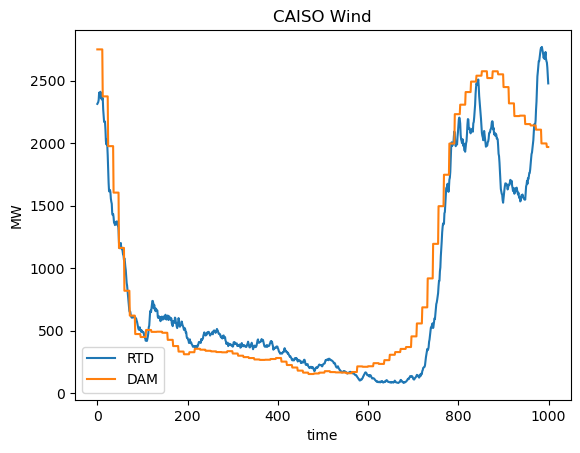

In [15]:
# Example data
x = np.arange(0, 1000, 1)  # Common x-axis values for both lines
ya = RTDWind['CAISO'].values[0:1000]  # First set of y-axis values
yb = DAMWind['CAISO'].values[0:1000]  # Second set of y-axis values

# Create the plot
plt.plot(x, ya, label='RTD')  # Plot the first line
plt.plot(x, yb, label='DAM')  # Plot the second line

# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('MW')  # Replace with your Y-axis label
plt.title('CAISO Wind')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()


In [16]:
actual_values = np.where(RTDSolar['CAISO'].values == 0, np.nan, RTDSolar['CAISO'].values)

RTDSolarMAE = np.nanmean(np.abs((RTDSolar['CAISO'].values - DAMSolar['CAISO'])))

RTDWindMAE = sum(abs((RTDWind['CAISO'].values - DAMWind['CAISO'].values)))/105109
RTDSolarMAE

362.0485513682168

In [17]:
RTDSolarNoise = (DAMSolar - RTDSolar)/max(DAMSolar['CAISO'])
RTDWindNoise = (DAMWind - RTDWind)/max(DAMWind['CAISO'])

In [18]:
RTDWindNoise['CAISO'].mean()

0.034037161688030164

In [19]:
closest_solar, _ = pairwise_distances_argmin_min(kmeans_solar.cluster_centers_, reshaped_data_solar)
noise_list_solar = []
for i in closest_solar:
    selected_rows = RTDSolarNoise.iloc[288*i:288*(i+1)].values
    noise_list_solar.append(selected_rows)
noise_list_solar = np.stack(noise_list_solar)

In [20]:
closest_wind, _ = pairwise_distances_argmin_min(kmeans_wind.cluster_centers_, reshaped_data_wind)
noise_list_wind = []
for i in closest_wind:
    selected_rows = RTDWindNoise.iloc[288*i:288*(i+1)]
    noise_list_wind.append(selected_rows)
noise_list_wind = np.stack(noise_list_wind)

### ADS day-ahead renewable pattern prediction

In [21]:
ADSSolar = pd.read_csv('Processed Data/SolarZone_C.csv')[['0','1','2']]
ADSWind = pd.read_csv('Processed Data/WindZone_C.csv')[['0','1','2']]
solarratio = ADSSolar['1'].values/(ADSSolar['1'].values+ADSSolar['2'].values)
solarratio = np.nan_to_num(solarratio, nan=np.nanmean(solarratio))
windratio = ADSWind['1'].values/(ADSWind['1'].values+ADSWind['2'].values)
solarratio = np.repeat(solarratio, 12, axis=0)
windratio = np.repeat(windratio, 12, axis=0)


ADSSolar['CAISO'] = ADSSolar[['0', '1', '2']].sum(axis=1)
ADSSolar['Zone1'] = ADSSolar['0']
ADSSolar['Zone2&3'] = ADSSolar[['1', '2']].sum(axis=1)
ADSSolar = ADSSolar[['CAISO', 'Zone1', 'Zone2&3']]

ADSWind['CAISO'] = ADSWind[['0', '1', '2']].sum(axis=1)
ADSWind['Zone1'] = ADSWind['0']
ADSWind['Zone2&3'] = ADSWind[['1', '2']].sum(axis=1)
ADSWind = ADSWind[['CAISO', 'Zone1', 'Zone2&3']]

reshaped_ADSSolar = ADSSolar.values.reshape(-1, 24*3)/max(ADSSolar['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features
reshaped_ADSWind = ADSWind.values.reshape(-1, 24*3)/max(ADSWind['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features

C:\Users\wenmi\AppData\Local\Temp\ipykernel_17564\3715211229.py:3: RuntimeWarning: invalid value encountered in divide
  solarratio = ADSSolar['1'].values/(ADSSolar['1'].values+ADSSolar['2'].values)


In [22]:
ADSWind['CAISO'].max()/train_pre_wind['CAISO'].max()

1.2267171045643412

In [23]:
predictions_solar = kmeans_solar.predict(reshaped_ADSSolar)
predictions_wind = kmeans_wind.predict(reshaped_ADSWind)


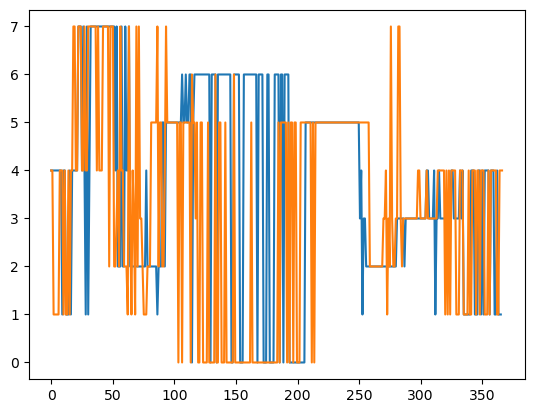

In [24]:
# Generate some data
x3 = np.linspace(0, 366, 366)
y3 = predictions_solar

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x1, y1)

# Plot the data
ax.plot(x3, y3)

# Show the plot
plt.show()

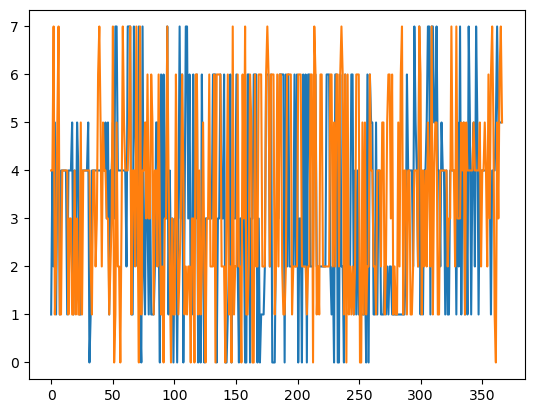

In [25]:
# Generate some data
x4 = np.linspace(0, 366, 366)
y4 = predictions_wind

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x2, y2)

# Plot the data
ax.plot(x4, y4)

# Show the plot
plt.show()

### Apply noise to ADS load base on prediciton

In [26]:
noise_list_solar_ADS = max(ADSSolar['CAISO'])*noise_list_solar
noise_list_wind_ADS = max(ADSWind['CAISO'])*noise_list_wind

In [27]:
ADSSolar_repeated = ADSSolar.loc[ADSSolar.index.repeat(12)].reset_index(drop=True)
ADSWind_repeated = ADSWind.loc[ADSWind.index.repeat(12)].reset_index(drop=True)

In [28]:
ADSRTDSolar = np.empty((0, 3))
for i in range(len(reshaped_ADSSolar)):
    adjust = -noise_list_solar_ADS[predictions_solar[i]]+ADSSolar_repeated[i*288:i*288+288].values
    ADSRTDSolar = np.vstack((ADSRTDSolar, adjust))

In [29]:
ADSRTDWind = np.empty((0, 3))
for i in range(len(reshaped_ADSWind)):
    adjust = -noise_list_wind_ADS[predictions_wind[i]]+ADSWind_repeated[i*288:i*288+288].values
    ADSRTDWind = np.vstack((ADSRTDWind, adjust))

In [30]:
ADSRTDSolar123 = np.vstack((ADSRTDSolar[:,1],solarratio*ADSRTDSolar[:,2],(1-solarratio)*ADSRTDSolar[:,2])).T
ADSRTDWind123 = np.vstack((ADSRTDWind[:,1],windratio*ADSRTDWind[:,2],(1-windratio)*ADSRTDWind[:,2])).T
ADSRTDSolar123[ADSRTDSolar123 < 0] = 0
ADSRTDWind123[ADSRTDWind123 < 0] = 0


### Append rest regions

In [31]:
ADSSolar_rest = pd.read_csv("./Processed Data/2022/SolarZone_C.csv")[['3','4','5','6']]
new_index = np.arange(ADSSolar_rest.index.min(), ADSSolar_rest.index.max() + 1, 1/12)
ADSSolar_rest_reindexed = ADSSolar_rest.reindex(new_index)
ADSSolar_rest_interpolated = ADSSolar_rest_reindexed.interpolate(method='linear')
ADSWind_rest = pd.read_csv("./Processed Data/2022/WindZone_C.csv")[['3','4','5','6']]
new_index = np.arange(ADSWind_rest.index.min(), ADSWind_rest.index.max() + 1, 1/12)
ADSWind_rest_reindexed = ADSWind_rest.reindex(new_index)
ADSWind_rest_interpolated = ADSWind_rest_reindexed.interpolate(method='linear')
ADSSolar_rest_interpolated.values

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [32]:
ADSSolar_RTD = np.hstack((ADSRTDSolar123, ADSSolar_rest_interpolated))
np.savetxt("realtimesolar.csv", ADSSolar_RTD, delimiter=",")
ADSWind_RTD = np.hstack((ADSRTDWind123, ADSWind_rest_interpolated))
np.savetxt("realtimewind.csv", ADSWind_RTD, delimiter=",")